In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings("ignore")

np.random.seed(42)
%matplotlib inline

In [2]:
#reading in data
adult = pd.read_csv('./adult.csv',header=None)

In [3]:
#setting column names
adult.columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 
                 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 
                 'hours-per-week', 'native-country', 'income']

In [4]:
# replacing ' ?' with null values to better handle the missing data
adult['workclass'].replace(' ?', np.NaN).isna().sum()

adult['workclass'].replace(' ?', np.NaN, inplace=True)

adult['occupation'].replace(' ?', np.NaN).isna().sum()

adult['occupation'].replace(' ?', np.NaN, inplace=True)

adult['native-country'].replace(' ?', np.NaN).isna().sum()

adult['native-country'].replace(' ?', np.NaN, inplace=True)

In [5]:
# replacing the - in the native country columns
adult['native-country'] = adult['native-country'].replace('-', ' ', regex=True)

In [6]:
#checking the baseline score of our model
adult['income'].value_counts(normalize=True)

 <=50K    0.75919
 >50K     0.24081
Name: income, dtype: float64

In [7]:
#dummifying the columns where needed
adult_dummied = pd.get_dummies(adult, columns=['workclass', 'marital-status', 'occupation', 
                                               'relationship', 'race', 'sex', 'income'], drop_first=True,)

In [8]:
# importing the modeling libraries
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix

In [9]:
# instantiating the scaler
ss = StandardScaler()


In [10]:
#setting X and y
X = adult_dummied[['age', 'education-num', 'capital-gain',
       'capital-loss', 'hours-per-week',
       'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc',
       'workclass_ Self-emp-not-inc', 'workclass_ State-gov',
       'workclass_ Without-pay', 'marital-status_ Married-AF-spouse',
       'marital-status_ Married-civ-spouse',
       'marital-status_ Married-spouse-absent',
       'marital-status_ Never-married', 'marital-status_ Separated',
       'marital-status_ Widowed', 'occupation_ Armed-Forces',
       'occupation_ Craft-repair', 'occupation_ Exec-managerial',
       'occupation_ Farming-fishing', 'occupation_ Handlers-cleaners',
       'occupation_ Machine-op-inspct', 'occupation_ Other-service',
       'occupation_ Priv-house-serv', 'occupation_ Prof-specialty',
       'occupation_ Protective-serv', 'occupation_ Sales',
       'occupation_ Tech-support', 'occupation_ Transport-moving',
       'relationship_ Not-in-family', 'relationship_ Other-relative',
       'relationship_ Own-child', 'relationship_ Unmarried',
       'relationship_ Wife', 'race_ Asian-Pac-Islander', 'race_ Black',
       'race_ Other', 'race_ White', 'sex_ Male']]
y=adult['income']

In [11]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y)

In [12]:
#transforming the data
X_trainss = ss.fit_transform(X_train)

X_testss = ss.transform(X_test)

logreg = LogisticRegression()


poly = PolynomialFeatures()

In [13]:
#using polynomial feature for more columns
new_poly = poly.fit_transform(X_trainss, y_train)

In [14]:
#Transforming the data
new_poly_test = poly.transform(X_testss)

In [15]:
#Fitting transformed data into logreg model
logreg.fit(new_poly, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [16]:
#scoring the training data
logreg.score(new_poly, y_train,)

0.8634316134316135

In [17]:
#Scoring the testing data
logreg.score(new_poly_test, y_test)

0.8545633214592802

In [18]:
#instantiate random forrest
trees = RandomForestClassifier(max_depth=10,min_samples_split=4)

In [19]:
#fitting model
trees.fit(new_poly, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [20]:
#scoring training and testing data(train)
trees.score(new_poly,y_train)

0.8769451269451269

In [21]:
#scoring training and testing data(test)
trees.score(new_poly_test, y_test)

0.8656184743888957

In [22]:
#Fitting an adaboost model to see how it changes the score
adaboost = AdaBoostClassifier()

adaboost.fit(new_poly, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [23]:
#train data score
adaboost.score(new_poly, y_train)

0.8640868140868141

In [24]:
#test data score
adaboost.score(new_poly_test,y_test)

0.8619334234123572

In [25]:
#Adaboost scores the highest so we will make our predictions with that
preds = adaboost.predict(new_poly_test)

In [26]:
#using the trees model to compare confustion matrix
preds2 = trees.predict(new_poly_test)

In [27]:
#using SKLearn to make the confusion matrix to check against the plotting function
confusion_matrix(y_test, preds)

array([[5791,  390],
       [ 734, 1226]])

In [28]:
#function to plot the confusion matrix 
def plot_confusion_matrix(cm, target_names, title='Random Forest Confusion matrix', cmap=plt.cm.coolwarm):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

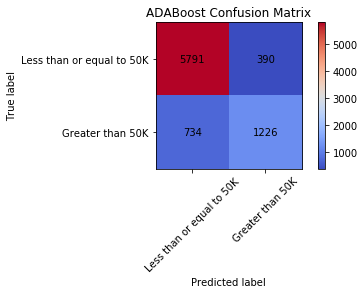

In [33]:
# Plot confusion matrix for adaboost
plt.figure()
cm = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm,title="ADABoost Confusion Matrix", target_names=['Less than or equal to 50K','Greater than 50K']);

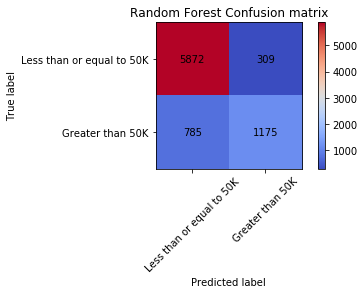

In [30]:
# Plot confusion matrix for random forest
plt.figure()
cm = confusion_matrix(y_test, preds2)
plot_confusion_matrix(cm, ['Less than or equal to 50K','Greater than 50K']);